In [1]:
# To import functions from utils.py, which is in the parent diretory

import sys
import os

current_dir = os.path.dirname(os.path.abspath('__file__')) 

parent_dir = os.path.dirname(current_dir)

sys.path.append(parent_dir)

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from collections import defaultdict
from sklearn.model_selection import GroupKFold
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb
import lightgbm as lgb
import warnings
from custom_imputer import ColumnwiseIterativeImputer
warnings.filterwarnings("ignore")

sns.set_style("whitegrid")



In [3]:
data=pd.read_csv("../3. EDA and data preprocessing/preprocessed_training_data.csv")

with open("../3. EDA and data preprocessing/time_dependent_clinical_features.txt", 'r') as file:
    clinical_feature_time_dependent = file.readlines()
clinical_feature_time_dependent = [item.strip() for item in clinical_feature_time_dependent]

with open("../3. EDA and data preprocessing/static_clinical_features.txt", 'r') as file:
    clinical_feature_non_time_dependent = file.readlines()
clinical_feature_non_time_dependent = [item.strip() for item in clinical_feature_non_time_dependent] 

### By our analysis in the baseline model, extracting signals from past information, so we create some lagged variables.

In [4]:
updrs_cols = ['updrs_1', 'updrs_2', 'updrs_3']
cols_to_lag = updrs_cols + clinical_feature_time_dependent

data = data.sort_values(['participant_id', 'visit_month'])

for lag in [1, 2, 3]: 
    for col in cols_to_lag:
        data[f'{col}_lag_{lag}'] = data.groupby('participant_id')[col].shift(lag)

lagged_feature_cols = [col for col in data.columns if '_lag_' in col]

final_feature_cols = clinical_feature_non_time_dependent + lagged_feature_cols

updrs_lagged_cols = [col for col in data.columns if ('_lag_' in col) and ("updrs" in col)]

other_lagged_cols = [col for col in final_feature_cols if col  in lagged_feature_cols and col not in updrs_lagged_cols]

non_lagged_feature_cols = [col for col in final_feature_cols if not (('_lag_' in col))]

### We need to consider how to impute the lagged features carefully since we cannot access future information -- We used a fill by 0 as our initial strategy. Moreover, as we observed in the EDA that the updrs scores have a correlation with each other, we will use the Multiple Imputation by Chained Equations (MICE) imputer for the lagged UPDRS scores.

In [ ]:
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

mae_results = {}
mae_results["0"]=defaultdict(list)
mae_results["1"]=defaultdict(list)
mae_results["2"]=defaultdict(list)

cv_split_generator = gkf.split(data, groups=data["participant_id"])

imputation_recipe = {
    'updrs_3_lag_1': ['updrs_3_lag_2','updrs_3_lag_3', 'updrs_1_lag_2', 'updrs_1_lag_3', 'updrs_2_lag_3',],
    
    'updrs_2_lag_1': ['updrs_3_lag_3','updrs_3_lag_3', 'updrs_1_lag_2', 'updrs_3_lag_3', 'updrs_3_lag_3',],

    'updrs_3_lag_2': ['updrs_3_lag_3','updrs_2_lag_3', 'updrs_1_lag_3'],

    'updrs_2_lag_2': ['updrs_3_lag_3','updrs_2_lag_3', 'updrs_1_lag_3'],

    'updrs_3_lag_3': [],

    'updrs_2_lag_3': []
}


for fold, (train_idx, test_idx) in enumerate(cv_split_generator):
    train_fold = data.iloc[train_idx]
    holdout_fold = data.iloc[test_idx]


    X_train, y_train = train_fold[final_feature_cols], train_fold[updrs_cols]
    X_holdout, y_holdout = holdout_fold[final_feature_cols], holdout_fold[updrs_cols]

    preprocessor = ColumnTransformer(
        transformers=[
            ('imputer_on_lagged_updrs', ColumnwiseIterativeImputer(imputation_mapping=imputation_recipe), updrs_lagged_cols),
            ('imputer_on_other_lagged_features', SimpleImputer(strategy='constant', fill_value=0), other_lagged_cols),
            ('clinical_imputer', SimpleImputer(strategy='median'), non_lagged_feature_cols)
        ],
        remainder='passthrough'
    )

    preprocessor.fit(X_train)

    X_train_imputed = pd.DataFrame(preprocessor.transform(X_train), columns=final_feature_cols, index=X_train.index)
    X_holdout_imputed = pd.DataFrame(preprocessor.transform(X_holdout), columns=final_feature_cols, index=X_holdout.index)


    y_train_clean = y_train.dropna()
    X_train_clean = X_train_imputed.loc[y_train_clean.index]

    xgb_estimator = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=1000,  
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=216,
        n_jobs=-1,
        tree_method='hist' 
    )
    model1 = MultiOutputRegressor(xgb_estimator)


    rf = RandomForestRegressor(n_estimators=100, random_state=216, n_jobs=-1)
    model2 = MultiOutputRegressor(rf)

    lgbm_estimator = lgb.LGBMRegressor(
        objective='regression_l1',
        n_estimators=1000,
        learning_rate=0.05,
        num_leaves=31,
        max_depth=-1,
        n_jobs=-1,
        random_state=216,
        verbose=-1
    )
    model3 = MultiOutputRegressor(lgbm_estimator)

    models=[model1, model2, model3]
    for i, model in enumerate(models):
      model.fit(X_train_clean, y_train_clean)

      predictions_array = model.predict(X_holdout_imputed)
      predictions_df = pd.DataFrame(predictions_array, index=X_holdout.index, columns=updrs_cols)

      for col in updrs_cols:
          actual_values = y_holdout[col]
          predicted_values = predictions_df[col]

          valid_indices = actual_values.notna()
          mae = mean_absolute_error(actual_values[valid_indices], predicted_values[valid_indices])

          mae_results[f"{i}"][col].append(mae)
          


In [7]:
for i in range(0,3):
  if i==0:
    print("\n--- Cross-Validation Results for XG Boosting w/ Lags ---")
  elif i==1:
    print("\n--- Cross-Validation Results for Random Forest w/ Lags ---")
  else:
    print("\n--- Cross-Validation Results for LightGBM w/ Lags ---")
  for col, scores in mae_results[f"{i}"].items():
      avg_mae = np.mean(scores)
      std_mae = np.std(scores)
      mae_results[f"{i}"][col] = avg_mae
      print(f"Average MAE for {col}: {avg_mae:.4f} (+/- {std_mae:.4f})")


--- Cross-Validation Results for XG Boosting w/ Lags ---
Average MAE for updrs_1: 2.7746 (+/- 0.0128)
Average MAE for updrs_2: 2.7496 (+/- 0.0329)
Average MAE for updrs_3: 5.9177 (+/- 0.1335)

--- Cross-Validation Results for Random Forest w/ Lags ---
Average MAE for updrs_1: 2.8091 (+/- 0.0198)
Average MAE for updrs_2: 2.7729 (+/- 0.0390)
Average MAE for updrs_3: 5.9907 (+/- 0.1374)

--- Cross-Validation Results for LightGBM w/ Lags ---
Average MAE for updrs_1: 2.6604 (+/- 0.0324)
Average MAE for updrs_2: 2.5663 (+/- 0.0483)
Average MAE for updrs_3: 5.7013 (+/- 0.1377)


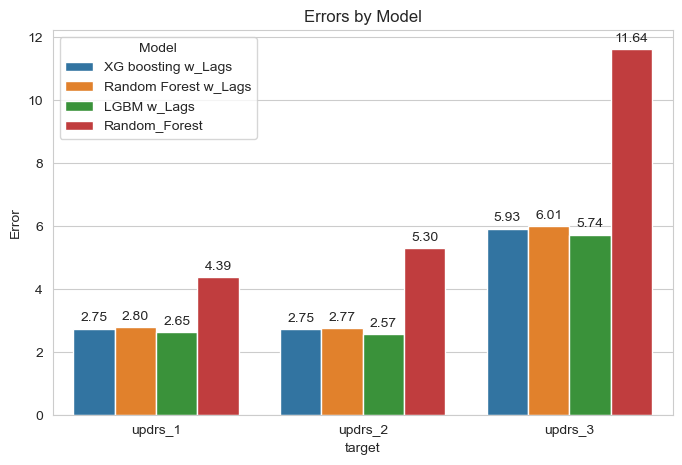

In [7]:
mae_averages = {i: {target: np.mean(np.array(mae_results[i][target])) for target in mae_results[i]} for i in mae_results}

baseline_errors = pd.read_csv("../4. baseline models/baseline_model_errors.csv")

df = pd.DataFrame.from_dict(mae_averages, orient='index').reset_index().rename(columns={'index': 'Model'})

df['Model'] = ["XG boosting w_Lags", "Random Forest w_Lags", "LGBM w_Lags"]

df = pd.concat([df, baseline_errors], ignore_index=True)

df.to_csv("mae_for_tree_models_with_lags.csv", index_label="model")

# preserve only the strongest baseline model
df = df.drop([3,4])

long_df = df.melt(id_vars='Model', var_name='target', value_name='error').dropna()

plt.figure(figsize=(8, 5))
ax = sns.barplot(data=long_df, x='target', y='error', hue='Model')
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', padding=3)
plt.title('Errors by Model')
plt.ylabel('Error')
plt.show()


In [8]:
df.to_csv("mae_for_tree_models_with_lags.csv", index_label="model")

# Observations:

Compared to the baseline models, the tree models with lags achieved a large improvement. This confirm with our knowledge about time series data: the trend is the most important feature.

Since the LightGBM model has the best performance here, we will use that model in the subsequent modelling process.

In order to prepare for the later feature engineering, we roughly look at the feature importance for the LightBGM model in the last fold.


--- Feature Importance (from last fold's model) ---
Top 20 Features (Averaged Across UPDRS Targets):
                                        updrs_1  updrs_2  updrs_3  \
updrs_1_lag_1                              1844     2673     3008   
age_at_baseline                            1202     2852     3294   
updrs_3_lag_1                              1845     2501     2142   
updrs_3_lag_2                              1463     2589     1765   
visit_month                                1446      880     3161   
updrs_1_lag_2                              1310      649     2459   
updrs_1_lag_3                              1219     2311      642   
updrs_3_lag_3                              1400      850     1557   
updrs_2_lag_1                              1204     1826      713   
updrs_2_lag_2                              1009     1872      471   
updrs_2_lag_3                               856     1120     1292   
other_relative_with_pd                       81     1470      410   
s

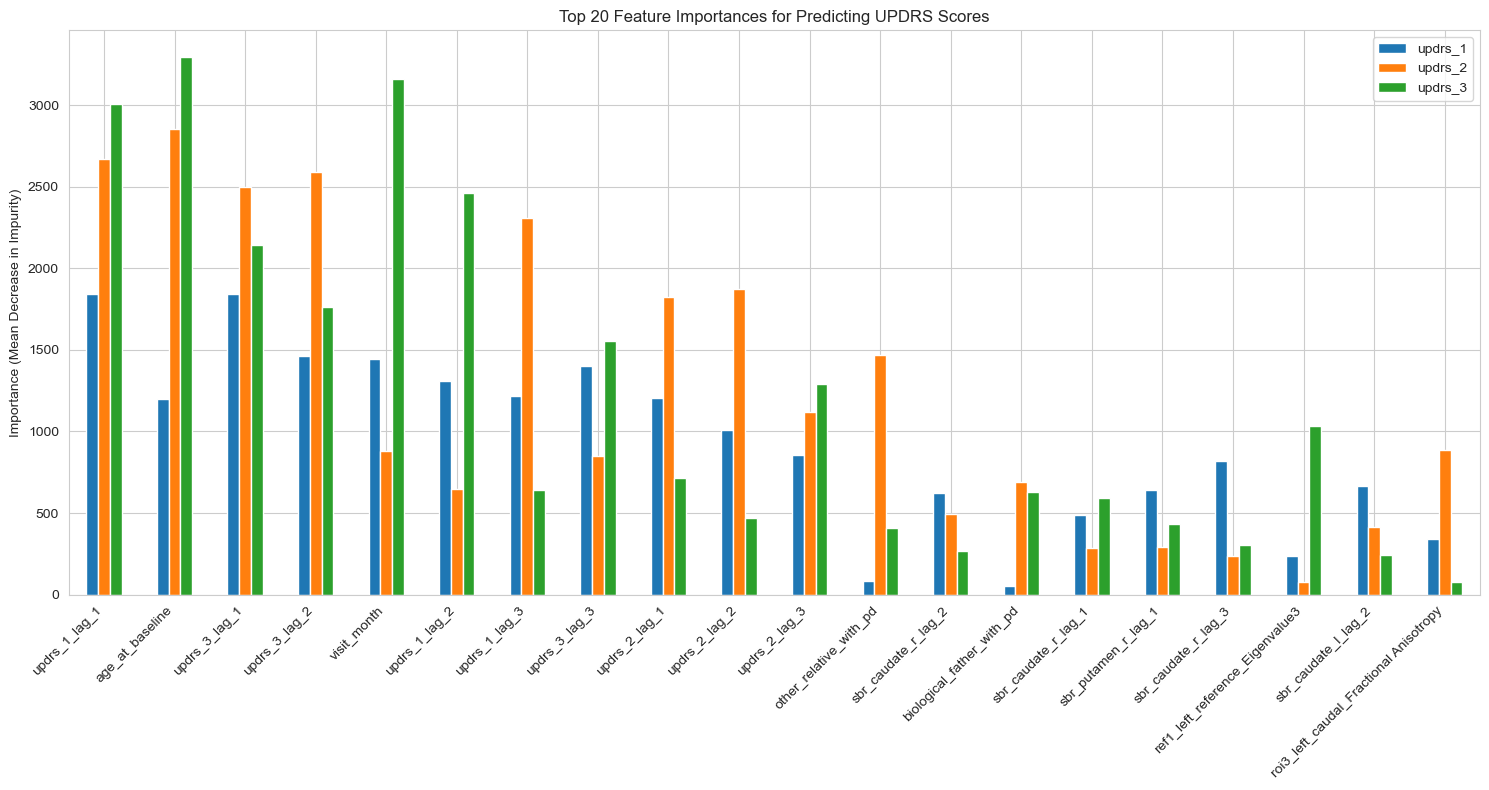

In [9]:
model=models[-1]
print("\n--- Feature Importance (from last fold's model) ---")
importance_df = pd.DataFrame(index=final_feature_cols)

for i, estimator in enumerate(model.estimators_):
    target_name = updrs_cols[i]
    importances = estimator.feature_importances_
    importance_df[target_name] = importances

importance_df['average_importance'] = importance_df.mean(axis=1)
importance_df.to_csv("feature_importance_LGBM.csv")
top_features = importance_df.sort_values(by='average_importance', ascending=False).head(20)

print("Top 20 Features (Averaged Across UPDRS Targets):")
print(top_features)

top_features[updrs_cols].plot(kind='bar', figsize=(15, 8))
plt.title('Top 20 Feature Importances for Predicting UPDRS Scores')
plt.ylabel('Importance (Mean Decrease in Impurity)')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Analysis

### The Patient's Most Recent History has great importance:

The most important features by a large margin will be the lagged versions of the UPDRS scores themselves. This confirms with our intuition that the disease is strongly autoregressive: the best predictor of a patient's near-future state is their immediate past state.

### Time and Age are Fundamental:

`visit_month` and `age_at_baseline` will be the next most important features. They provide the fundamental context of "where" the patient is in their disease timeline and their biological starting point.

### Other Clinical Markers Provide Additional Signal:

Lagged, time-dependent clinical features, especially the SBR (striatal binding ratio) imaging markers like sbr_putamen_r_lag_1, will likely rank as moderately important. They provide predictive information that the lagged UPDRS scores alone don't capture.

### Other Static Demographics are Less Impactful:

The remaining static features (e.g., race, education level) will have much lower importance scores compared to the dynamic (time-varying) features.